# Exploring Calibrated Data with ctapipe

In [1]:
import ctapipe
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.io import event_source, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u
import numpy as np
%matplotlib inline
plt.style.use("ggplot")

In [2]:
print(ctapipe.__version__)
print(ctapipe.__file__)

0.6.0.post2+gitc875493
/Users/kosack/Projects/CTA/Working/ctapipe/ctapipe/__init__.py


Let's first open a raw event file and get an event out of it:

In [3]:
filename = get_dataset_path("gamma_test.simtel.gz")
#filename = "/Users/kosack/Data/CTA/Prod3b/gamma/gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz"
source = event_source(filename, max_events=2)

for event in source:
    print(event.r0.event_id)

408
409


In [4]:
filename

'/Users/kosack/Projects/CTA/Working/ctapipe-extra/ctapipe_resources/gamma_test.simtel.gz'

In [5]:
source

In [6]:
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

In [7]:
print(event.r1)

{'event_id': 409,
 'obs_id': 31964,
 'tel': {},
 'tels_with_data': {11, 21, 118, 119, 24, 26, 61, 63}}


## Perform basic calibration:

Here we will use a `CameraCalibrator` which is just a simple wrapper that runs the three calibraraton and trace-integration phases of the pipeline, taking the data from levels:

  **R0** &rightarrow; **R1** &rightarrow; **DL0** &rightarrow; **DL1**

You could of course do these each separately, by using the classes `R1Calibrator`, `DL0Reducer`, and `DL1Calibrator`.
Note that we have not specified any configuration to the `CameraCalibrator`, so it will be using the default algorithms and thresholds, other than specifying that the product is a "HESSIOR1Calibrator" (hopefully in the near future that will be automatic).

In [8]:
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(r1_product="HESSIOR1Calibrator")
calib.calibrate(event)

Now the *r1*, *dl0* and *dl1* containers are filled in the event

* **r1.tel[x]**: contains the "r1-calibrated" waveforms, after gain-selection, pedestal subtraciton, and gain-correction
* **dl0.tel[x]**: is the same but with optional data volume reduction (some pixels not filled), in this case this is not performed by default, so it is the same as r1
* **dl1.tel[x]**: contains the (possibly re-calibrated) waveforms as dl0, but also the time-integrated *image* that has been calculated using a `ChargeExtractor` (a `NeighborPeakIntegrator` by default)

In [9]:
for tel_id in event.dl1.tel:
    print("TEL{:03}: {}".format(tel_id, event.inst.subarray.tel[tel_id]))
    print("  - r0  wave shape  : {}".format(event.r0.tel[tel_id].waveform.shape))
    print("  - r1  wave shape  : {}".format(event.r1.tel[tel_id].waveform.shape))
    print("  - dl1 image shape : {}".format(event.dl1.tel[tel_id].image.shape))

TEL011: MST:NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1, 1855, 30)
  - dl1 image shape : (1, 1855)
TEL021: MST:NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1, 1855, 30)
  - dl1 image shape : (1, 1855)
TEL118: MST-SCT:SCTCam
  - r0  wave shape  : (1, 11328, 32)
  - r1  wave shape  : (1, 11328, 32)
  - dl1 image shape : (1, 11328)
TEL119: MST-SCT:SCTCam
  - r0  wave shape  : (1, 11328, 32)
  - r1  wave shape  : (1, 11328, 32)
  - dl1 image shape : (1, 11328)
TEL024: MST:NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1, 1855, 30)
  - dl1 image shape : (1, 1855)
TEL026: MST:NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1, 1855, 30)
  - dl1 image shape : (1, 1855)
TEL061: SST-ASTRI:CHEC
  - r0  wave shape  : (1, 2048, 25)
  - r1  wave shape  : (1, 2048, 25)
  - dl1 image shape : (1, 2048)
TEL063: SST-ASTRI:CHEC
  - r0  wave shape  : (1, 2048, 25)
  - r1  wave shape  : (1, 2048, 25)
  - dl1 image 

## Some image processing:

Let's look at the image

In [10]:
from ctapipe.visualization import CameraDisplay
tel_id = list(event.r1.tels_with_data)[0]
sub = event.inst.subarray
camera = sub.tel[tel_id].camera
image = event.dl1.tel[tel_id].image[0] 

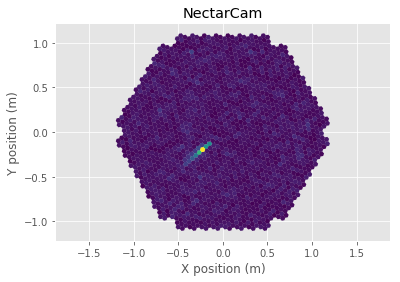

In [11]:
disp = CameraDisplay(camera, image=image)

In [12]:
from ctapipe.image import tailcuts_clean, hillas_parameters

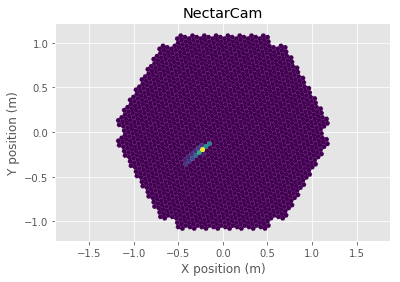

In [13]:
mask = tailcuts_clean(camera, image, picture_thresh=10, boundary_thresh=5)
cleaned = image.copy()
cleaned[~mask] = 0
disp = CameraDisplay(camera, image=cleaned)


In [14]:
%timeit hillas_parameters(camera, cleaned)
%timeit hillas_parameters(camera[mask], image[mask])

501 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
826 µs ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
params = hillas_parameters(camera, cleaned)
print(params)
params

{'intensity': 308.48246946723589,
 'kurtosis': 2.6732650093113324,
 'length': <Quantity 0.09084822176052741 m>,
 'phi': <Angle -2.448803746044367 rad>,
 'psi': <Angle -2.4719801804249366 rad>,
 'r': <Quantity 0.338627993478974 m>,
 'skewness': 0.52882408097740119,
 'width': <Quantity 0.017469780256816517 m>,
 'x': <Quantity -0.2605633285500886 m>,
 'y': <Quantity -0.21627683598225358 m>}


ctapipe.io.containers.HillasParametersContainer:
                     intensity: total intensity (size)
                             x: centroid x coordinate
                             y: centroid x coordinate
                             r: radial coordinate of centroid
                           phi: polar coordinate of centroid [deg]
                        length: RMS spread along the major-axis
                         width: RMS spread along the minor-axis
                           psi: rotation angle of ellipse [deg]
                      skewness: measure of the asymmetry
                      kurtosis: measure of the tailedness

(-0.5, 0.2)

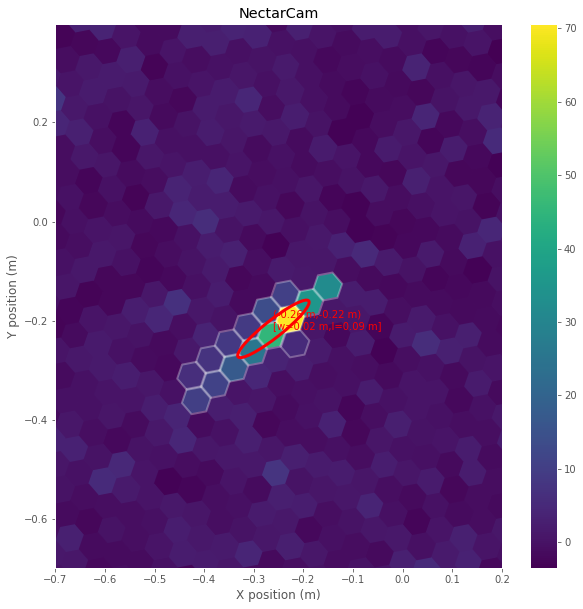

In [16]:
params = hillas_parameters(camera, cleaned)

plt.figure(figsize=(10,10))
disp = CameraDisplay(camera, image=image)
disp.add_colorbar()
disp.overlay_moments(params, color='red', lw=3)
disp.highlight_pixels(mask, color='white', alpha=0.3, linewidth=2)
plt.xlim(-0.7,0.2)
plt.ylim(-0.5,0.2)

In [17]:
source.metadata

{'is_simulation': True}

## More complex image processing:

Let's now explore how stereo reconstruction works. 

### first, look at a summed image from multiple telescopes

For this, we want to use a `CameraDisplay` again, but since we can't sum and display images with different cameras, we'll just sub-select images from a particular camera type

These are the telescopes that are in this event:

In [18]:
tels_in_event = set(event.dl1.tel.keys())  # use a set here, so we can intersect it later
tels_in_event

{11, 21, 24, 26, 61, 63, 118, 119}

In [19]:
cam_ids = set(sub.get_tel_ids_for_type("MST:NectarCam"))

In [20]:
cams_in_event = tels_in_event.intersection(cam_ids)
first_tel_id = list(cams_in_event)[0]
tel = sub.tel[first_tel_id]
print("{}s in event: {}".format(tel, cams_in_event))

MST:NectarCams in event: {24, 26, 11, 21}


Now, let's sum those images:

In [22]:
image_sum = np.zeros_like(tel.camera.pix_x.value)  # just make an array of 0's in the same shape as the camera 

for tel_id in cams_in_event:
    image_sum += event.dl1.tel[tel_id].image[0]

And finally display the sum of those images

Text(0.5,1,'Sum of 4x MST:NectarCam')

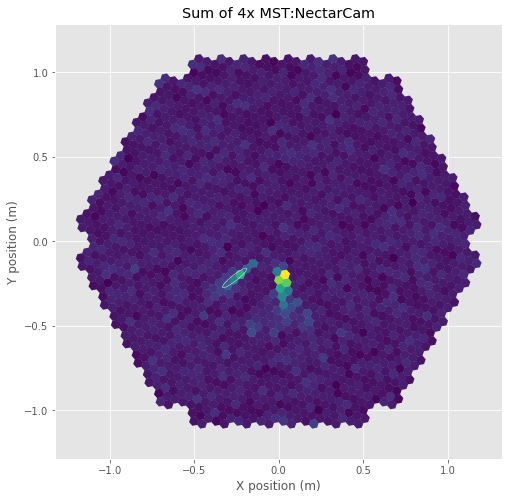

In [23]:
plt.figure(figsize=(8,8))

disp = CameraDisplay(tel.camera, image=image_sum)
disp.overlay_moments(params, with_label=False)
plt.title("Sum of {}x {}".format(len(cams_in_event), tel))

let's also show which telescopes those were. Note that currently ArrayDisplay's value field is a vector by `tel_index`, not `tel_id`, so we have to convert to a tel_index. (this may change in a future version to be more user-friendly)


In [24]:
from ctapipe.visualization import ArrayDisplay

<Figure size 432x288 with 0 Axes>

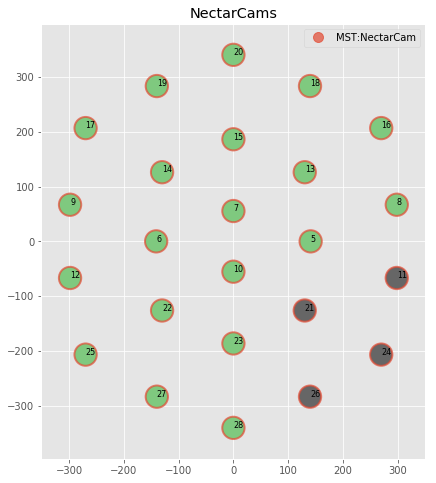

In [25]:
nectarcam_subarray = sub.select_subarray("NectarCams", cam_ids)

hit_pattern = np.zeros(shape=nectarcam_subarray.num_tels)
hit_pattern[[nectarcam_subarray.tel_indices[x] for x in cams_in_event ]] = 100

plt.set_cmap(plt.cm.Accent)
plt.figure(figsize=(8,8))

ad = ArrayDisplay(nectarcam_subarray)
ad.values = hit_pattern
ad.add_labels()
